In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from scipy import stats
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import re
import string
import warnings
warnings.filterwarnings('ignore')

In [46]:
df = pd.read_csv('processed.csv')
sorted(df.columns)

['Active connections: source08 CPR',
 'Active connections: source08 DSR',
 'Active connections: source09 CPR',
 'Active connections: source09 DSR',
 'Active connections: source10 CPR',
 'Active connections: source10 DSR',
 'Available db connection activity: source01 CPR',
 'Available db connection activity: source04 CPR',
 'Available db connection activity: source04 DSR',
 'Available db connection activity: source08 CPR',
 'Available db connection activity: source08 DSR',
 'Available db connection activity: source09 CPR',
 'Available db connection activity: source09 DSR',
 'Class loading activity',
 'Class unloading activity',
 'Connection delay: source01 CPR',
 'Connection delay: source01 DSR',
 'Connection delay: source02 CPR',
 'Connection delay: source02 DSR',
 'Connection delay: source03 CPR',
 'Connection delay: source03 DSR',
 'Connection delay: source04 CPR',
 'Connection delay: source04 DSR',
 'Connection delay: source05 CPR',
 'Connection delay: source05 DSR',
 'Connection de

**We drop unwanted columns**

In [47]:
df.drop(columns=['Unnamed: 0', 'weekday', 'hour'], inplace=True)

In [48]:
anomalies = df[df['isAnomaly']==1]
regular = df[df['isAnomaly']==0]
anomalies['timestamp']

9795    2015-02-09 17:00:00
9796    2015-02-09 17:01:00
9797    2015-02-09 17:02:00
9798    2015-02-09 17:03:00
9799    2015-02-09 17:04:00
9800    2015-02-09 17:05:00
9801    2015-02-09 17:06:00
9802    2015-02-09 17:07:00
9803    2015-02-09 17:08:00
9804    2015-02-09 17:09:00
9805    2015-02-09 17:10:00
9806    2015-02-09 17:11:00
9807    2015-02-09 17:12:00
9808    2015-02-09 17:13:00
9809    2015-02-09 17:14:00
9810    2015-02-09 17:15:00
9811    2015-02-09 17:16:00
9812    2015-02-09 17:17:00
9813    2015-02-09 17:18:00
9814    2015-02-09 17:19:00
9815    2015-02-09 17:20:00
Name: timestamp, dtype: object

### Training set
We create the training set in the following manner:
* Extract about 60% of rows with anomalies
* Sample 2500 rows from regular dataframe
* Combine the two

In [49]:
train1 = anomalies[anomalies['timestamp'] <='2015-02-09 17:12:00']
train2 = regular.take(np.random.permutation(len(regular))[:2500])
train_ = pd.concat([train1, train2], axis=0)
train = train_.sample(frac=1).reset_index(drop=True)
train = train.drop(columns='timestamp')
train.shape

(2513, 100)

### Testing set
Similarly, we create the testing set in the following manner:
* Extract remaining of rows with anomalies
* Sample 2500 of unused rows from regular dataframe
* Combine the two

In [50]:
test1 = anomalies[anomalies['timestamp'] <='2015-02-09 17:12:00']
regular_less_train2 = regular.drop(index=train2.index)
test2 = regular_less_train2.take(np.random.permutation(len(regular_less_train2))[:2500])
test_ = pd.concat([test1, test2], axis=0)
test = test_.sample(frac=1).reset_index(drop=True)
test = test.drop(columns='timestamp')

test.shape

(2513, 100)

In [51]:
X_train = train.drop(columns='isAnomaly')
y_train = train['isAnomaly']

X_test = test.drop(columns='isAnomaly')
y_test = test['isAnomaly']

### Remove redundant/highly correlated features

In [52]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [53]:
final_iv, IV = data_vars(X_train, y_train)

In [54]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train[features]
X2.head()

,Available db connection activity: source09 CPR,Available db connection activity: source09 DSR,Connection delay: source03 CPR,Connection delay: source03 DSR,Connection delay: source05 CPR,Connection delay: source05 DSR,Connection delay: source06 CPR,Connection delay: source06 DSR,Connection delay: source08 CPR,Connection delay: source08 DSR,...,Rel. heap usage,Rel. nonHeap committed,Rel. nonHeap usage,Rel. open file descriptors,Rel. physical mem usage,Rel. unavailable connections: source09 CPR,System CPU,Thread CPU time,Thread User time,Total thread count
0,0.0,0.0,100.0,100.0,53.0,53.0,44.0,44.0,0.0,0.0,...,0.172119,0.854789,0.805242,0.153320,0.644946,0.000000,0.008,5.869280e+12,5.751650e+12,77.0
1,0.0,0.0,100.0,100.0,53.0,53.0,44.0,44.0,0.0,0.0,...,0.114131,0.858865,0.810281,0.152832,0.620999,0.000000,0.005,3.561229e+12,3.390310e+12,77.0
2,0.0,0.0,80.0,80.0,66.0,66.0,68.0,68.0,82.0,82.0,...,0.208686,0.864640,0.825179,0.165283,0.607169,0.000000,0.009,2.198815e+12,2.132880e+12,94.0
3,-4.0,-4.0,80.0,80.0,66.0,66.0,68.0,68.0,0.0,0.0,...,0.215076,0.949558,0.732491,0.144043,0.631778,0.166667,0.049,1.321809e+11,1.276000e+11,73.0
4,1.0,1.0,77.0,77.0,65.0,65.0,67.0,67.0,0.0,0.0,...,0.279500,0.824558,0.822002,0.153809,0.556998,0.250000,0.162,1.088060e+12,1.053130e+12,112.0


In [55]:
def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        
        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')

X1 = X2._get_numeric_data()
final_df, final_vif = iterate_vif(X1)

Iteration # 1
Removing Connection delay: source08 CPR with VIF of 3270207984.090807
Iteration # 2
Removing Connection delay: source09 CPR with VIF of 368700898.810482
Iteration # 3
Removing Connection delay: source06 CPR with VIF of 83706845.343087
Iteration # 4
Removing Connection delay: source03 CPR with VIF of 85758795.928020
Iteration # 5
Removing Connection delay: source05 CPR with VIF of 54747609.256284
Iteration # 6
Removing Connection delay: source06 DSR with VIF of 119110.743916
Iteration # 7
Removing Daemon thread count with VIF of 79439.503753
Iteration # 8
Removing Thread CPU time with VIF of 19179.715491
Iteration # 9
Removing Rel. nonHeap committed with VIF of 77126.229058
Iteration # 10
Removing Process CPU: OS with VIF of 282.332612
Iteration # 11
Removing Rel. heap committed with VIF of 263.569904
Iteration # 12
Removing Rel. nonHeap usage with VIF of 159.157631
Iteration # 13
Removing Rel. heap usage with VIF of 101.998249
Iteration # 14
Removing Connection delay: sou

In [56]:
X_train=final_df
X_train.head()

,Available db connection activity: source09 DSR,Connection delay: source05 DSR,Connection delay: source08 DSR,Connection delay: source09 DSR,GC activity: Scavenge,Heap committed activity,Last GC duration: Marksweep,Last GC duration: Scavenge,Memory space activity: PS Eden Space committed,Memory space activity: PS Eden Space used,...,Memory space usage: PS Survivor Space used,NonHeap usage activity,Physical mem activity,Prepared statement cache hit rate,Rel. open file descriptors,Rel. physical mem usage,Rel. unavailable connections: source09 CPR,System CPU,Thread User time,Total thread count
0,0.0,53.0,0.0,67.0,1.0,15728640.0,932.0,24.0,0.000098,-0.010585,...,0.073087,0.0,10731520.0,1.066667,0.153320,0.644946,0.000000,0.008,5.751650e+12,77.0
1,0.0,53.0,0.0,67.0,1.0,-15204352.0,911.0,22.0,-0.000427,-0.035769,...,0.958445,0.0,23863296.0,1.459459,0.152832,0.620999,0.000000,0.005,3.390310e+12,77.0
2,0.0,66.0,82.0,79.0,0.0,0.0,937.0,27.0,0.000000,0.014217,...,0.350334,0.0,2281472.0,0.872727,0.165283,0.607169,0.000000,0.009,2.132880e+12,94.0
3,-4.0,66.0,0.0,77.0,4.0,-87556096.0,951.0,42.0,-0.014098,0.014756,...,0.260413,2072.0,139755520.0,0.867114,0.144043,0.631778,0.166667,0.049,1.276000e+11,73.0
4,1.0,65.0,0.0,92.0,3.0,35651584.0,829.0,81.0,0.000002,-0.206196,...,0.417337,33072.0,9322496.0,0.752026,0.153809,0.556998,0.250000,0.162,1.053130e+12,112.0


In [57]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve




def run_regression_accuracy(X_train, y_train, X_test, y_test):
  logreg = LogisticRegression()
  logreg.fit(X_train, y_train)
  y_pred = logreg.predict(X_test)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
  cm = confusion_matrix(y_test, y_pred)
  print('\nConfusion matrix: \n',cm)

  print('\nClassification report: \n',classification_report(y_test, y_pred))

  logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
  fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()
  
  return logreg

In [58]:
X_test=X_test[X_train.columns]
X_test.head()

,Available db connection activity: source09 DSR,Connection delay: source05 DSR,Connection delay: source08 DSR,Connection delay: source09 DSR,GC activity: Scavenge,Heap committed activity,Last GC duration: Marksweep,Last GC duration: Scavenge,Memory space activity: PS Eden Space committed,Memory space activity: PS Eden Space used,...,Memory space usage: PS Survivor Space used,NonHeap usage activity,Physical mem activity,Prepared statement cache hit rate,Rel. open file descriptors,Rel. physical mem usage,Rel. unavailable connections: source09 CPR,System CPU,Thread User time,Total thread count
0,0.0,53.0,0.0,67.0,0.0,0.0,1151.0,28.0,0.000000,0.015831,...,0.142755,0.0,-3235840.0,1.701818,0.149658,0.304099,0.000000,0.006,2.243700e+12,77.0
1,0.0,65.0,0.0,88.0,0.0,0.0,897.0,20.0,0.000000,0.013883,...,0.129623,0.0,22528000.0,0.677686,0.140137,0.655338,0.000000,0.004,5.543280e+12,111.0
2,-1.0,66.0,82.0,81.0,0.0,0.0,1424.0,53.0,0.000000,0.455360,...,0.295297,9000.0,-413696.0,1.107700,0.180420,0.424026,0.076923,0.041,1.466330e+12,96.0
3,0.0,65.0,0.0,88.0,1.0,3145728.0,897.0,22.0,0.000015,-0.006194,...,0.417682,0.0,2351104.0,1.271468,0.140381,0.653877,0.000000,0.004,1.409130e+12,112.0
4,0.0,53.0,0.0,69.0,0.0,0.0,862.0,108.0,0.000000,0.017422,...,0.694386,0.0,-8613888.0,1.529038,0.138184,0.585758,0.000000,0.004,1.121300e+11,76.0


Accuracy of logistic regression classifier on test set: 0.99

Confusion matrix: 
 [[2500    0]
 [  13    0]]

Classification report: 
               precision    recall  f1-score   support

       False       0.99      1.00      1.00      2500
        True       0.00      0.00      0.00        13

    accuracy                           0.99      2513
   macro avg       0.50      0.50      0.50      2513
weighted avg       0.99      0.99      0.99      2513



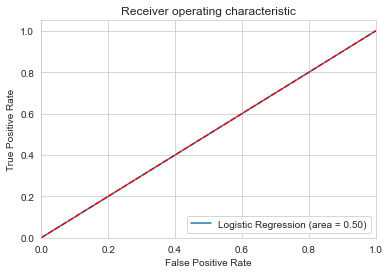

In [59]:
logreg = run_regression_accuracy(X_train, y_train, X_test, y_test)

# Modeling
### Model 1: Random Forest Classifier

In [17]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 10, random_state = 42, max_depth=50, class_weight=dict({1:48, 0:1}), verbose=2)
# Train the model on training data
rf.fit(X_train, y_train)

y_pred1 = rf.predict(X_test)

roc1 = roc_auc_score(y_test, y_pred1)

roc1

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


1.0

In [18]:
conf1 = confusion_matrix(y_test, y_pred1)
conf1

array([[2500,    0],
       [   0,   13]], dtype=int64)

### Model 2: Logistic Regression

In [19]:
# Import the model we are using
from sklearn.linear_model import LogisticRegression

# Instantiate model
lr = LogisticRegression(C=1, tol=0.1, multi_class='ovr', class_weight=dict({1:49, 0:1}), solver='newton-cg', max_iter=10, n_jobs=-1, verbose=2)
# Train the model on training data
lr.fit(X_train, y_train)

y_pred2 = lr.predict(X_test)

roc2 = roc_auc_score(y_test, y_pred2)

roc2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s finished


0.7473384615384615

In [20]:
conf2 = confusion_matrix(y_test, y_pred2.round())
conf2

array([[1429, 1071],
       [   1,   12]], dtype=int64)

### Model 3: XGBoost Classifier

In [21]:
# Import the model we are using
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Instantiate model with 100 decision trees
xgb = XGBClassifier(n_estimators = 10, max_depth=30, max_delta_step=4, scale_pos_weight=49, random_state = 42, verbosity=2, n_jobs=-1)
# Train the model on training data
xgb.fit(X_train, y_train)

y_pred3 = xgb.predict(X_test)

roc3 = roc_auc_score(y_test, y_pred3)

roc3

[11:32:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:32:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:32:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:32:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:32:14]

0.9998

In [22]:
conf3 = confusion_matrix(y_test, y_pred3.round())
conf3

array([[2499,    1],
       [   0,   13]], dtype=int64)

### Hyperparameter Tuning
We decide to go with XGBoost classifier

In [23]:
def algorithm_pipeline(X_train, X_test, y_train, y_test, \
                       model, param_grid, cv=10, scoring_fit='ne_mean_squared_error', do_probabilities=False):
    gs = GridSearchCV(estimator=model, \
                      param_grid=param_grid, \
                      cv=cv, \
                      n_jobs=-1, \
                      scoring=scoring_fit, \
                      verbose=2)
    
    fitted_model = gs.fit(X_train, y_train)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test)
    else:
        pred = fitted_model.predict(X_test)
    return fitted_model, pred

In [24]:
param_grid = {'eta': [0.01, 0.05, 0.1], \
              'max_depth': [9, 10, 11], \
              'scale_pos_weight': [49, 50, 51], \
              'max_delta_step': [4, 6, 8], \
              'grow_policy':['depthwise', 'losswise']}

model = XGBClassifier( n_jobs=32, random_state = 42, verbosity=2)

In [25]:
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, param_grid, cv=10, scoring_fit='roc_auc')

Fitting 10 folds for each of 162 candidates, totalling 1620 fits
[11:33:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:33:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:33:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:33:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:33:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree p

In [26]:
print(model.best_score_)
print(model.best_params_)

1.0
{'eta': 0.1, 'grow_policy': 'depthwise', 'max_delta_step': 4, 'max_depth': 9, 'scale_pos_weight': 49}


In [27]:
xgb = XGBClassifier(eta=0.1, max_depth=11, scale_pos_weight=49, max_delta_step=8, grow_policy='depthwise', n_jobs=-1, random_state = 42, verbosity=2)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

roc = roc_auc_score(y_test, y_pred)

roc

[11:33:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:33:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:33:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:33:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:33:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[11:33:04]

0.9998

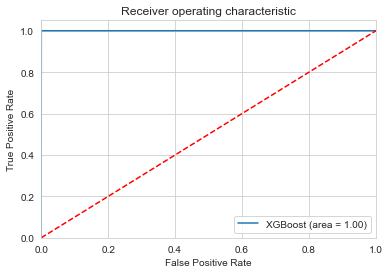

In [28]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)

sns.set_style('whitegrid')
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('XGB_ROC')
plt.show()

In [29]:
conf = confusion_matrix(y_test, y_pred.round())
conf

array([[2499,    1],
       [   0,   13]], dtype=int64)

### Feature Importance

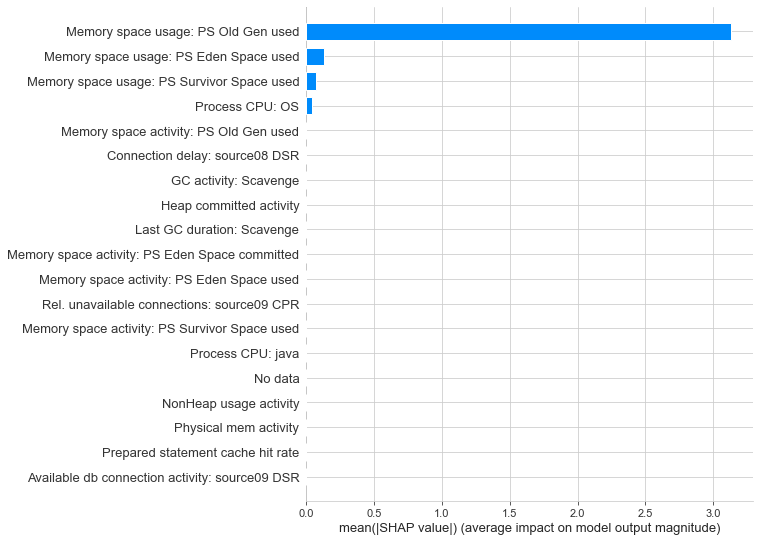

In [30]:
shap_values = shap.TreeExplainer(xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

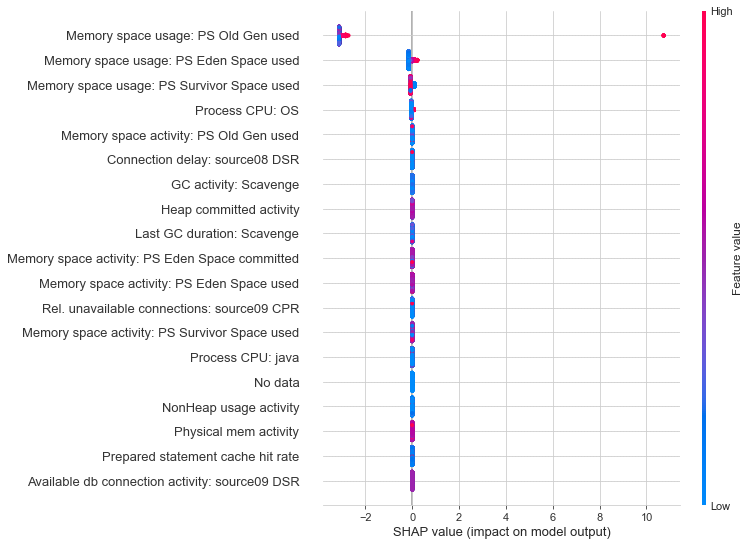

In [31]:
shap.summary_plot(shap_values, X_train)

In [33]:
mean1 = X_train['Memory space usage: PS Old Gen used'].mean()
mean2 = X_train['Memory space usage: PS Eden Space used'].mean()
mean3 = X_train['Memory space usage: PS Survivor Space used'].mean()
mean4 = X_train['Process CPU: OS'].mean()

In [37]:
print("Cutoff for 'Memory space usage: PS Old Gen used'is: {}".format(round(mean1*0.75, 3)))
print("Cutoff for 'Memory space usage: PS Eden Space used'is: {}".format(round(mean2*0.75, 3)))
print("Cutoff for 'Memory space usage: PS Survivor Space usedd'is: {}".format(round(mean3*0.75, 3)))
print("Cutoff for 'Process CPU: OS'is: {}".format(round(mean4*0.75, 3)))

Cutoff for 'Memory space usage: PS Old Gen used'is: 0.165
Cutoff for 'Memory space usage: PS Eden Space used'is: 0.101
Cutoff for 'Memory space usage: PS Survivor Space usedd'is: 0.43
Cutoff for 'Process CPU: OS'is: 0.028
